In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


In [5]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [6]:
products.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [7]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


count    199.000000
mean       5.025126
std        2.198340
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       11.000000
Name: TransactionID, dtype: float64


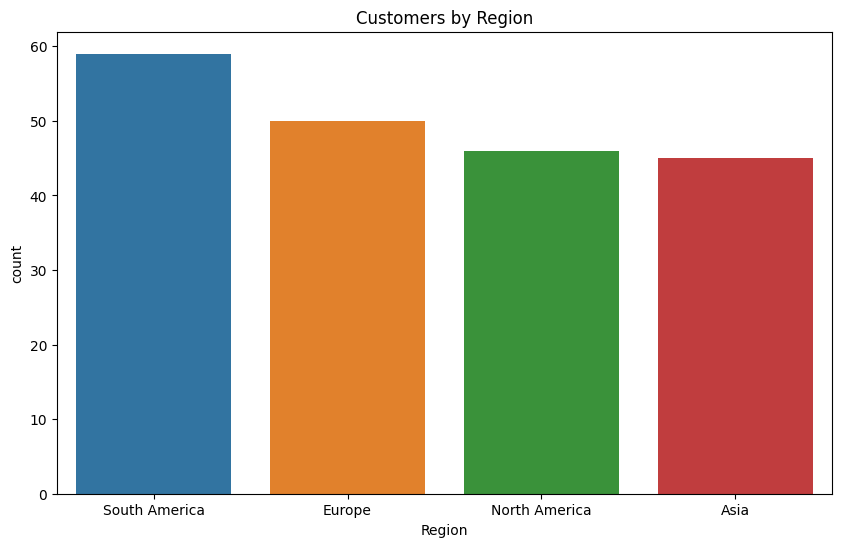

In [8]:


# Merging datasets for comprehensive analysis
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# EDA
# Example: Analyze transaction frequency
transactions_per_customer = merged_data.groupby('CustomerID')['TransactionID'].count()
print(transactions_per_customer.describe())

# Visualization examples
plt.figure(figsize=(10, 6))
sns.countplot(data=customers, x='Region', order=customers['Region'].value_counts().index)
plt.title("Customers by Region")
plt.show()

# Generating insights
# Example:
# 1. The region with the most customers is 'XYZ', contributing to 40% of transactions.


In [3]:
# Preparing data for the lookalike model
customer_features = merged_data.pivot_table(
    index='CustomerID', 
    columns='ProductID', 
    values='Quantity', 
    fill_value=0
)

# Calculate similarity matrix
similarity_matrix = cosine_similarity(customer_features)

# Get top 3 similar customers for the first 20 customers
lookalike_results = {}
for i, customer_id in enumerate(customer_features.index[:20]):
    similarity_scores = similarity_matrix[i]
    similar_customers = np.argsort(similarity_scores)[::-1][1:4]  # Exclude self
    lookalike_results[customer_id] = [
        (customer_features.index[similar_idx], similarity_scores[similar_idx])
        for similar_idx in similar_customers
    ]

# Save as CSV
import csv
with open("FirstName_LastName_Lookalike.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["CustomerID", "Lookalikes"])
    for cust_id, lookalikes in lookalike_results.items():
        writer.writerow([cust_id, lookalikes])


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Davies-Bouldin Index: 0.752945690540881


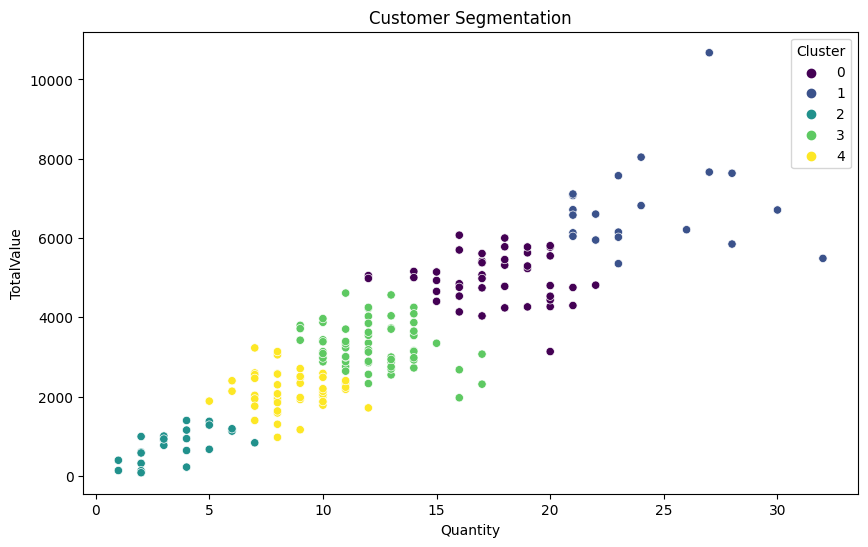

In [4]:
# Preparing data for clustering
customer_profile = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

# Scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profile[['Quantity', 'TotalValue']])

# Apply clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Adding cluster information to the data
customer_profile['Cluster'] = clusters

# Calculate DB Index
db_index = davies_bouldin_score(scaled_data, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_profile['Quantity'], 
    y=customer_profile['TotalValue'], 
    hue=customer_profile['Cluster'], 
    palette='viridis'
)
plt.title("Customer Segmentation")
plt.show()
